In [1]:

import plot_functions
import compare_clusterings
import process_data
import visualizations

from compare_clusterings import *
from process_data import *
from plot_functions import *
from visualizations import *

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

In [3]:
import traj_generator

In [4]:
import numpy as np
import plotly.graph_objs as go

In [5]:
import numpy as np

# Parameters
num_points = 100
num_groups = 4  # Allow for all strategies to be represented
space_size = 10
timesteps = 200
noise_level = 0.1
group_change_interval = 50

# Initialize points
positions = np.random.rand(num_points, 3) * space_size  # Random 3D positions
velocities = np.random.rand(num_points, 3) - 0.5        # Random initial velocities
group_assignments = np.random.randint(0, num_groups, num_points)  # Random group assignments

# Shared parameters for group motions
group_motion_types = np.random.choice([1, 2, 3, 4], size=num_groups)  # Assign strategies (1, 2, 3, or 4)
group_base_velocities = np.random.rand(num_groups, 3) - 0.5  # Shared velocities for Strategy 1
group_directions = np.random.rand(num_groups, 3) - 0.5       # Shared directions for Strategy 3
group_directions = group_directions / np.linalg.norm(group_directions, axis=1)[:, np.newaxis]  # Normalize directions

# Circular motion parameters
circular_directions = [np.random.rand(3) for _ in range(num_groups)]  # Rotation axes for Strategy 4
circular_directions = [d / np.linalg.norm(d) for d in circular_directions]  # Normalize rotation axes

# Initialize storage for the simulation
trajectory_data = np.zeros((num_points, timesteps, 4))  # (x, y, z, cluster)

def rotation_matrix_around_axis(axis, angle):
    """Create a 3D rotation matrix around a given axis."""
    axis = axis / np.linalg.norm(axis)
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
    u = axis
    return np.array([
        [cos_a + u[0]**2 * (1 - cos_a), u[0] * u[1] * (1 - cos_a) - u[2] * sin_a, u[0] * u[2] * (1 - cos_a) + u[1] * sin_a],
        [u[1] * u[0] * (1 - cos_a) + u[2] * sin_a, cos_a + u[1]**2 * (1 - cos_a), u[1] * u[2] * (1 - cos_a) - u[0] * sin_a],
        [u[2] * u[0] * (1 - cos_a) - u[1] * sin_a, u[2] * u[1] * (1 - cos_a) + u[0] * sin_a, cos_a + u[2]**2 * (1 - cos_a)],
    ])

def update_positions(positions, velocities, group_assignments, noise_level):
    """Update the positions of the points."""
    group_centers = np.zeros((num_groups, 3))
    group_counts = np.zeros(num_groups)
    
    # Compute group centers (for Strategy 2: Group Center Attraction)
    for i, pos in enumerate(positions):
        group = group_assignments[i]
        group_centers[group] += pos
        group_counts[group] += 1
    
    for g in range(num_groups):
        if group_counts[g] > 0:
            group_centers[g] /= group_counts[g]  # Average position for each group

    # Update positions based on group strategy
    for i, pos in enumerate(positions):
        group = group_assignments[i]
        strategy = group_motion_types[group]
        
        if strategy == 1:  # Shared Group Velocity Vector
            velocities[i] = group_base_velocities[group] + noise_level * (np.random.rand(3) - 0.5)
        
        elif strategy == 2:  # Group Center Attraction
            direction_to_center = group_centers[group] - pos
            if np.linalg.norm(direction_to_center) > 1e-6:  # Avoid division by zero
                velocities[i] = direction_to_center / np.linalg.norm(direction_to_center) + noise_level * (np.random.rand(3) - 0.5)
        
        elif strategy == 3:  # Shared Direction with Noise
            velocities[i] = group_directions[group] + noise_level * (np.random.rand(3) - 0.5)
            velocities[i] /= np.linalg.norm(velocities[i])  # Normalize to maintain direction
        
        elif strategy == 4:  # Circular Motion
            axis = circular_directions[group]
            angle = 0.1  # Constant angular step size
            rotation_matrix = rotation_matrix_around_axis(axis, angle)
            velocities[i] = np.dot(rotation_matrix, velocities[i])
        
        # Update position
        positions[i] += velocities[i]

    return positions

# Simulation
for t in range(timesteps):
    positions = update_positions(positions, velocities, group_assignments, noise_level)
    
    # Store positions and cluster assignments for each point at this timestep
    for i, pos in enumerate(positions):
        trajectory_data[i, t, :3] = pos  # Store x, y, z
        trajectory_data[i, t, 3] = group_assignments[i]  # Store cluster ID
    
    # Change group memberships periodically
    if t % group_change_interval == 0:
        group_assignments = np.random.randint(0, num_groups, num_points)

# The trajectory_data array contains the required format
# [[[x1_t1, y1_t1, z1_t1, cluster1_t1], [x1_t2, y1_t2, z1_t2, cluster1_t2], ...],
#  [[x2_t1, y2_t1, z2_t1, cluster2_t1], [x2_t2, y2_t2, z2_t2, cluster2_t2], ...], ...]

trajectories = trajectory_data


In [6]:
num_timesteps = len(trajectories[0])
num_particles = len(trajectories)
groups_list = np.array(trajectories)[:,:,-1]
num_groups = len(np.unique(np.array(groups_list).flatten()))

In [7]:
%matplotlib notebook

#a = plot_functions.plot_traj_labels_plt(trajectory_data, save_video=True, interval=100, filename="timestep_clustering_example.mp4")

In [8]:
#restructure for redpandda

In [9]:
flattened_data = []
trajectories = trajectories.tolist()
for obj_id, particle_data in enumerate(trajectories):
    for t, record in enumerate(particle_data):
        
        flattened_data.append([obj_id, t] + record)

df = pd.DataFrame(flattened_data, columns=['obj_id', 't', 'x', 'y', 'z', 'label'])

print(df)

       obj_id    t          x          y          z  label
0           0    0   7.209202   6.954367   7.803037    0.0
1           0    1   6.494016   6.344707   7.374045    1.0
2           0    2   5.848671   5.719253   7.006525    1.0
3           0    3   5.097186   5.198239   6.607916    1.0
4           0    4   4.372902   4.631451   6.384842    1.0
...       ...  ...        ...        ...        ...    ...
19995      99  195 -26.344344  15.832310  33.169592    0.0
19996      99  196 -26.774942  15.589470  33.222535    0.0
19997      99  197 -27.234071  15.369951  33.237441    0.0
19998      99  198 -27.749396  15.217138  33.232202    0.0
19999      99  199 -28.240543  14.987073  33.286647    0.0

[20000 rows x 6 columns]


# pair plot 1

In [10]:
import redpandda_general
traj_array, point_array, frames_count, n_objects = redpandda_general.prepare_data_from_df(df)

dist_matrices = redpandda_general.get_distance_matrices(traj_array)
delta_matrices = redpandda_general.get_delta_matrices(dist_matrices)
average_delta_matrix = redpandda_general.calculate_average_delta_matrix(delta_matrices)

std_delta_matrix = redpandda_general.get_std_matrices(dist_matrices)

stddv_matrices = redpandda_general.get_stddv(dist_matrices)

In [11]:
from timestep_clustering import compute_timstep_clustering, apply_rpt_change_detection

In [12]:
from sklearn.preprocessing import StandardScaler

In [ ]:
import clustering_functions
def full_workflow(delta_matrices, scale_embedding = False, change_point_detection=True, alternative_clustering_method="hdbscan", final_clustering_method="hdbscan"):
    embedding = compute_timstep_clustering(delta_matrices, title_type="Delta-matrices", dim_red="umap", metric="wasserstein", plot_dim_red=True, kde_plot=True, plot_heatmap=True)
    if isinstance(embedding, tuple):
        embedding = embedding[0]


    if scale_embedding:
        from sklearn.preprocessing import StandardScaler
        embedding = StandardScaler().fit_transform(embedding)

    if change_point_detection:
        change_points = apply_rpt_change_detection(embedding, pen=5)

        timestep_clusters = clustering_functions.cluster_timesteps_change_points(delta_matrices, change_points, "affinity")
        return timestep_clusters
    
    else:
        import hdbscan
        if alternative_clustering_method == "hdbscan":
            clusterer = hdbscan.HDBSCAN(min_cluster_size=5)  
            labels = clusterer.fit_predict(embedding[0])
        
        timestep_clusters_from_clustering = clustering_functions.cluster_timesteps_from_timestep_clustering(delta_matrices, labels, final_clustering_method)
        return timestep_clusters_from_clustering    

In [14]:
%matplotlib inline

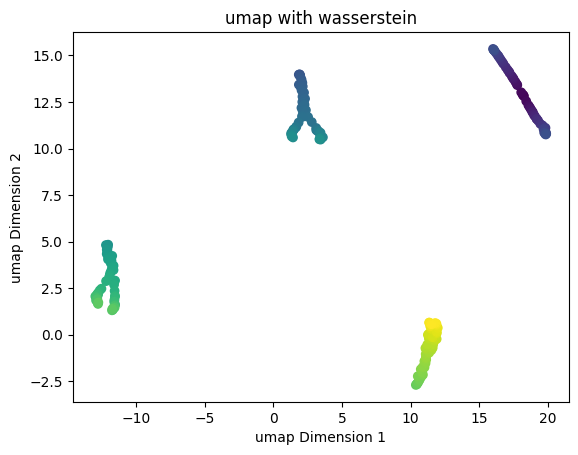

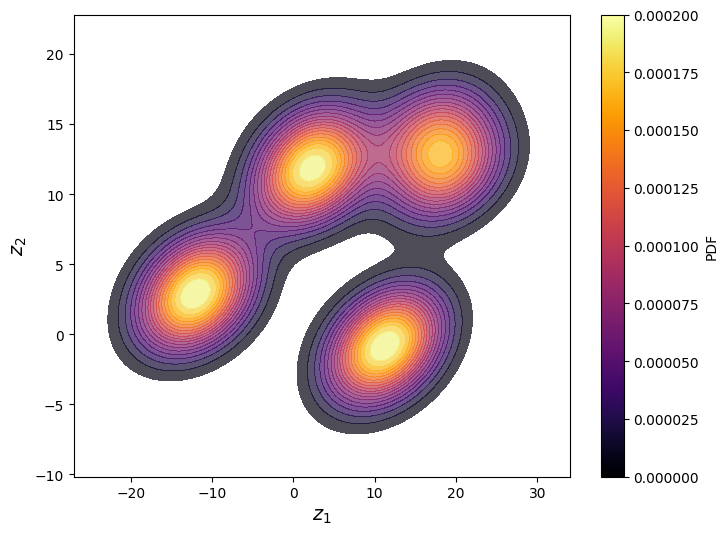

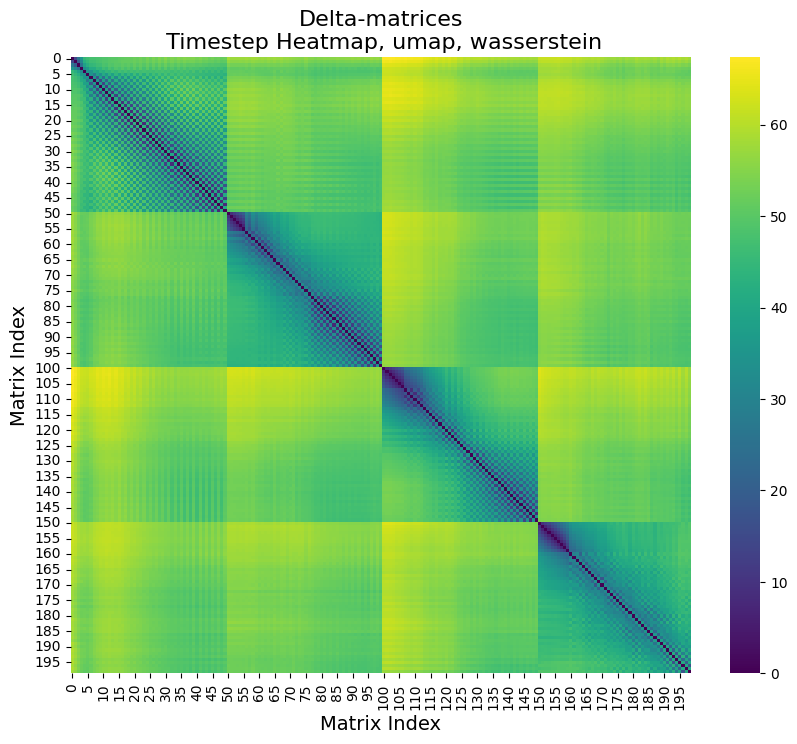

In [15]:
embedding = compute_timstep_clustering(delta_matrices, title_type="Delta-matrices", dim_red="umap", metric="wasserstein", plot_dim_red=True, kde_plot=True, plot_heatmap=True)

In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)  
labels = clusterer.fit_predict(embedding[0])

In [17]:
labels

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  5, -1,  5,  5,  5,  5,
        5,  5, -1, -1, -1, -1, -1,  3,  4,  3,  4,  3,  4,  3,  4,  3,  4,
        3,  4,  3,  4,  3,  4,  3,  4,  3,  4,  3,  4,  3,  4,  3,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2], dtype=int64)

In [18]:
change_points = apply_rpt_change_detection(embedding[0], pen=5)

In [19]:
import clustering_functions

In [20]:
timestep_clusters = clustering_functions.cluster_timesteps_change_points(delta_matrices, change_points, "affinity")

0.0058
0.0000
0.0163
0.0138


In [21]:
timestep_clusters

[{'start': 0,
  'end': 50,
  'clustering': array([7, 4, 2, 7, 5, 4, 3, 0, 1, 2, 7, 4, 1, 4, 5, 7, 4, 8, 1, 2, 3, 1,
         4, 2, 1, 6, 2, 3, 4, 3, 4, 3, 2, 1, 4, 4, 4, 1, 4, 4, 2, 2, 4, 2,
         8, 4, 4, 8, 2, 4, 2, 5, 4, 1, 4, 5, 3, 6, 2, 1, 8, 4, 2, 6, 8, 4,
         8, 7, 4, 2, 0, 0, 1, 7, 7, 2, 1, 4, 4, 8, 2, 2, 2, 8, 2, 2, 2, 2,
         2, 4, 1, 4, 3, 2, 2, 3, 7, 7, 8, 7], dtype=int64)},
 {'start': 51,
  'end': 100,
  'clustering': array([3, 0, 7, 5, 8, 3, 5, 8, 7, 5, 0, 3, 0, 0, 5, 1, 7, 0, 0, 7, 5, 5,
         3, 0, 5, 8, 0, 1, 3, 0, 3, 0, 5, 5, 0, 0, 3, 0, 0, 5, 7, 0, 5, 0,
         5, 6, 6, 5, 2, 3, 7, 0, 3, 0, 0, 0, 5, 5, 7, 0, 5, 5, 0, 5, 5, 0,
         0, 0, 5, 2, 4, 5, 5, 0, 1, 5, 5, 6, 0, 7, 0, 7, 5, 0, 5, 5, 7, 7,
         7, 3, 7, 0, 1, 0, 7, 5, 0, 1, 5, 8], dtype=int64)},
 {'start': 101,
  'end': 150,
  'clustering': array([0, 5, 5, 1, 0, 8, 6, 6, 6, 3, 6, 1, 6, 6, 6, 7, 6, 6, 1, 1, 1, 6,
         1, 2, 1, 1, 5, 6, 1, 8, 6, 6, 8, 1, 3, 3, 1, 1, 5, 8, 1, 2, 6, 2,


In [22]:
timestep_clusters_from_clustering = clustering_functions.cluster_timesteps_from_timestep_clustering(delta_matrices, labels, "affinity")

0.0100
0.0119
0.0471
0.0000
0.0000
0.0156
0.0000
0.0564


In [23]:
timestep_clusters_from_clustering

[{'indices': array([63, 70, 71, 72, 73, 74], dtype=int64),
  'clustering': array([0, 5, 1, 4, 7, 3, 4, 7, 0, 4, 5, 3, 5, 5, 4, 0, 6, 5, 5, 1, 4, 4,
         3, 5, 4, 7, 5, 0, 3, 5, 3, 4, 4, 4, 5, 5, 3, 5, 5, 4, 1, 5, 4, 5,
         4, 2, 6, 4, 3, 3, 1, 5, 3, 5, 5, 1, 1, 4, 1, 4, 4, 4, 5, 4, 4, 5,
         5, 5, 4, 3, 5, 4, 5, 5, 6, 4, 4, 2, 5, 6, 5, 1, 4, 5, 4, 4, 1, 1,
         1, 3, 7, 5, 3, 5, 1, 4, 5, 6, 4, 7], dtype=int64)},
 {'indices': array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
         113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
         139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149], dtype=int64),
  'clustering': array([8, 5, 5, 0, 8, 7, 6, 6, 6, 1, 6, 0, 6, 6, 6, 2, 6, 6, 0, 0, 0, 6,
         0, 3, 0, 0, 5, 6, 0, 7, 6, 6, 7, 0, 1, 1, 0, 0, 5, 7, 0, 3, 6, 3,
         7, 6, 6, 6, 6, 6, 4, 5, 5, 4, 1, 6, 0, 6, 4, 0, 7, 0, 3, 0, 0, 5,
         7, 7, 